In [1]:
from src.utils import data_load
import pandas as pd
import matplotlib.pyplot as plt
from src.s3_utils import pandas_from_csv_s3
import re
import datetime
import seaborn as sns
import numpy as np
from collections import defaultdict
import os
import pickle

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-aqfwka1g because the default path (/home/ubuntu/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
keys = {'oura_sleep', 'oura_activity', 'oura_readiness', 'oura_activity', 'birth'}
data = data_load(data_keys=keys, wave=5)

In [3]:
# oura_list = ['score_total', 'hr_average', 'temperature_delta', 'rmssd']
oura_sleep_list = ['awake', 'bedtime_end', 'bedtime_end_delta', 'bedtime_start', 'bedtime_start_delta', 'breath_average', 'deep', 'duration', 'efficiency', 'hr_average', 'hr_lowest', 'is_longest', 'light', 'midpoint_at_delta', 'midpoint_time', 'onset_latency', 'period_id', 'rem', 'restless', 'rmssd', 'score', 'score_alignment', 'score_deep', 'score_disturbances', 'score_efficiency', 'score_latency', 'score_rem', 'score_total', 'temperature_delta', 'temperature_deviation', 'temperature_trend_deviation', 'total']
oura_activity_list = ['average_met', 'cal_active', 'cal_total', 'daily_movement', 'day_end', 'day_start', 'high', 'inactive', 'inactivity_alerts', 'low', 'medium', 'met_1min', 'met_min_high', 'met_min_inactive', 'met_min_low', 'met_min_medium', 'non_wear', 'rest', 'rest_mode_state', 'score', 'score_meet_daily_targets', 'score_move_every_hour', 'score_recovery_time', 'score_stay_active', 'score_training_frequency', 'score_training_volume', 'steps', 'target_calories', 'target_km', 'target_miles', 'timezone', 'to_target_km', 'to_target_miles', 'total']
birth_list = ['user_id', 'birth_date', 'birth_scheduled', 'birth_gestage']

In [4]:
oura_df = data['oura_sleep'][['user_id', 'date'] + oura_sleep_list]
oura_df['date'] = pd.to_datetime(oura_df['date'])
birth_df = data['birth'][birth_list]
birth_df['birth_date'] = pd.to_datetime(birth_df['birth_date'])

In [5]:
len(birth_df['user_id'].unique())

245

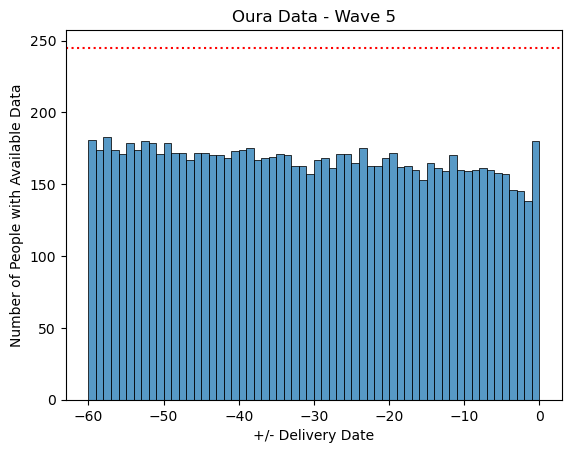

In [128]:
def plot_data_frequency(birth_df, data_df, start=None, end=None, title=None):
    frequency = []
    for uid in birth_df['user_id'].unique():
        df = data_df.loc[data_df['user_id'] == uid].sort_values(by='date')
        if len(df) > 0:
            birth_date = birth_df.loc[birth_df['user_id'] == uid]['birth_date'].tolist()[0]
            if start != None:
                df = df[(df['date'] >= birth_date + pd.to_timedelta(-start, unit='d'))]
            if end != None:
                df = df[(df['date'] <= birth_date + pd.to_timedelta(end, unit='d'))]
            # df = df.dropna()
            df['int_time'] = df['date'].apply(lambda x: (x - birth_date).days)
            if len(df['int_time'].unique()) == len(df):
                frequency.extend(df['int_time'].tolist())
    bin_num = max(frequency) - min(frequency)
    sns.histplot(data=np.array(frequency), bins=bin_num)
    plt.xlabel('+/- Delivery Date')
    plt.ylabel('Number of People with Available Data')
    plt.axhline(y=len(birth_df), color='r', linestyle=':')
    if title != None:
        plt.title(title)
plot_data_frequency(birth_df, oura_df, start=60, end=0, title='Oura Data - Wave 5')

In [119]:
def fill_in_missing_dates(df, date_col_name = 'date', start_date=None, end_date=None, fill_val = np.nan, date_format='%Y-%m-%d'):
    df.set_index(date_col_name,drop=True,inplace=True)
    df.index = pd.to_datetime(df.index, format = date_format)
    idx = pd.date_range(start_date, end_date)
    # print('missing_dates are',idx.difference(df.index))
    df=df.reindex(idx,fill_value=fill_val)
    return df

In [120]:
processed_data = defaultdict(list,{ k:[] for k in oura_sleep_list + ['user_id'] })
before_days = 60
for uid in birth_df['user_id'].unique():
    df = oura_df.loc[oura_df['user_id'] == uid].sort_values(by='date')
    if len(df) > 0:
        birth_date = birth_df.loc[birth_df['user_id'] == uid]['birth_date'].tolist()[0]
        start_date = birth_date + pd.to_timedelta(-before_days + 1, unit='d')
        df = df[(df['date'] >= start_date)]
        df = df[(df['date'] <= birth_date)]

        if len(df) >= round(before_days * 0.8):
            if len(df) != before_days:
                df=fill_in_missing_dates(df, date_col_name='date', start_date=start_date, end_date=birth_date)
                df = df.interpolate(method='linear', limit_direction='both', axis=0)
            processed_data['user_id'].append(uid)
            for col in oura_sleep_list:
                processed_data[col].append(df[col].tolist())

In [ ]:
len(processed_data[col])

In [121]:
before_days = 60
filter_range = np.linspace(0,1,21) # % Missingness
number_of_samples = [0] * len(filter_range)
for i, threshold in enumerate(filter_range):
    for uid in birth_df['user_id'].unique():
        df = oura_df.loc[oura_df['user_id'] == uid].sort_values(by='date')
        if len(df) > 0:
            start_date = birth_date + pd.to_timedelta(-before_days + 1, unit='d')
            df = df[(df['date'] >= start_date)]
            df = df[(df['date'] <= birth_date)]
            if len(df) >= round(before_days * threshold):
                number_of_samples[i] += 1

Text(0.12, 0.01, '\n    Missingness threshold is cutoff percentage of missingness. E.g. When the missingness threshold is at 80%, \n    it shows how many people have data avaliable for at least 80% of the given time period.')

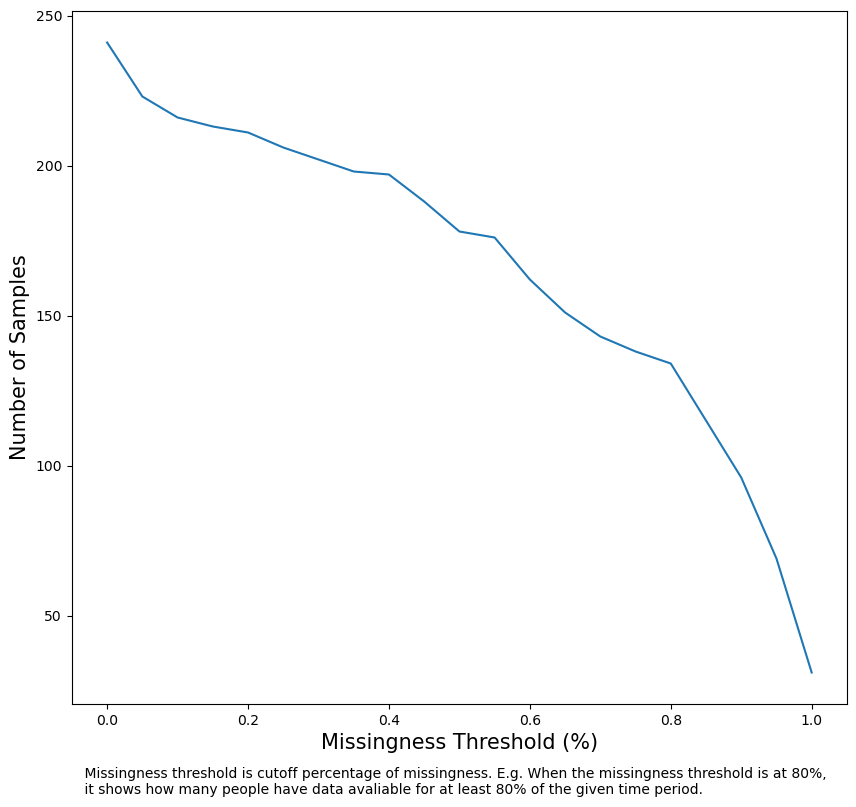

In [12]:
txt = '''
    Missingness threshold is cutoff percentage of missingness. E.g. When the missingness threshold is at 80%, 
    it shows how many people have data avaliable for at least 80% of the given time period.'''

fig, ax1 = plt.subplots()
fig.set_size_inches(10, 9)
ax1.set_xlabel('Missingness Threshold (%)', fontsize=15)
ax1.set_ylabel('Number of Samples', fontsize=15)
ax1.plot(filter_range, number_of_samples)
fig.text(.12, .01, txt)
plt.show()

In [122]:
for uid in processed_data['user_id']:
    newpath = f'/repos/Delivery-Readiness/data/bump_user_{int(uid)}' 
    if not os.path.exists(newpath):
        os.makedirs(newpath)

In [124]:
for col in oura_sleep_list:
    for i in range(len(processed_data[col])):
        uid = processed_data['user_id'][i]
        with open(f'/repos/Delivery-Readiness/data/bump_user_{int(uid)}/{col}_0.pkl', 'wb') as handle:
            pickle.dump(np.array([processed_data[col][i]]).T, handle)